In [1]:
#clean code - modeling

import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# 전역 변수로 설정
encoder = LabelEncoder()
param_dist_rf = {
    'n_estimators': [50, 100, 500],
    'max_leaf_nodes': [20, 30, 40, 50],
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

def load_and_preprocess_data(file_path, label_col_name, date_col_name):
    data = pd.read_csv(file_path, encoding='utf-8')
    data[label_col_name] = encoder.fit_transform(data[label_col_name])
    data[date_col_name] = pd.to_datetime(data[date_col_name])
    data.set_index(date_col_name, inplace=True)
    data.sort_index(inplace=True)
    return data

def train_and_save_model(data, label_col_name, model_save_path):
    X = data.drop(columns=[label_col_name])
    y = data[label_col_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
    time_split_cv = TimeSeriesSplit(n_splits=10)
    rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=time_split_cv, random_state=42)
    rnd_search.fit(X_train, y_train)
    best_clf = rnd_search.best_estimator_
    best_clf.fit(X_train, y_train)
    joblib.dump(best_clf, model_save_path)
    return best_clf

def predict_and_save(model, data, output_file_path, real_data_file_path, real_date_col_name):
    y_pred_labels = model.predict(data.drop(columns=['레이블']))
    y_pred_series = pd.Series(y_pred_labels, index=data.index, name='y_pred')
    real_data = pd.read_csv(real_data_file_path)
    real_data[real_date_col_name] = pd.to_datetime(real_data[real_date_col_name], format='%Y-%m-%d')
    real_data.set_index(real_date_col_name, inplace=True)
    common_start = max(data.index.min(), real_data.index.min())
    common_end = min(data.index.max(), real_data.index.max())
    data_common = data.loc[common_start:common_end]
    real_data_common = real_data.loc[common_start:common_end]
    real_data_with_pred = pd.merge(real_data_common, y_pred_series, left_index=True, right_index=True, how='left')
    real_data_with_pred.to_csv(output_file_path)


# 사용 예시

# 1단계: 데이터 로딩 및 전처리
# KS200 혹은 각 산업별 피쳐 데이터를 불러오고, '레이블'과 '날짜' 컬럼을 전처리합니다.
put_Data = load_and_preprocess_data('real_ks200.csv', '레이블', '날짜')

# 2단계: 모델 훈련 및 저장
# put_Data를 사용하여 모델을 훈련시키고, 훈련된 모델을 "f{각 산업의 앞 3글자}.pkl" 파일로 저장합니다.
best_clf = train_and_save_model(put_Data, '레이블', "real_ks200.pkl")

# 3단계: 예측 및 결과 저장
# 훈련된 모델(best_clf)를 사용하여 put_Data에 대한 예측을 수행하고, 
# "2.csv" 파일로부터 실제 데이터를 불러와 예측 결과와 병합한 후, 
# 최종 결과를 "f{각 산업의 앞 3글자_+test}.csv" 파일로 저장합니다.
predict_and_save(best_clf, put_Data, "real_ks200_test.csv", "../backtest/back.csv", "base_date")

In [2]:
# 모델 로딩
import pandas as pd

new_data = pd.read_csv('wnwkr.csv')
model = joblib.load('real_ks200.pkl')

# 예측
predictions = model.predict(new_data.drop(columns=['날짜']))

# 결과 출력
predictions

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

             지표   머신러닝 전략  buy&hold
0          CAGR -0.006782  0.003784
1           MDD -0.241209 -0.156375
2  Sharpe Ratio -0.133479  0.104968


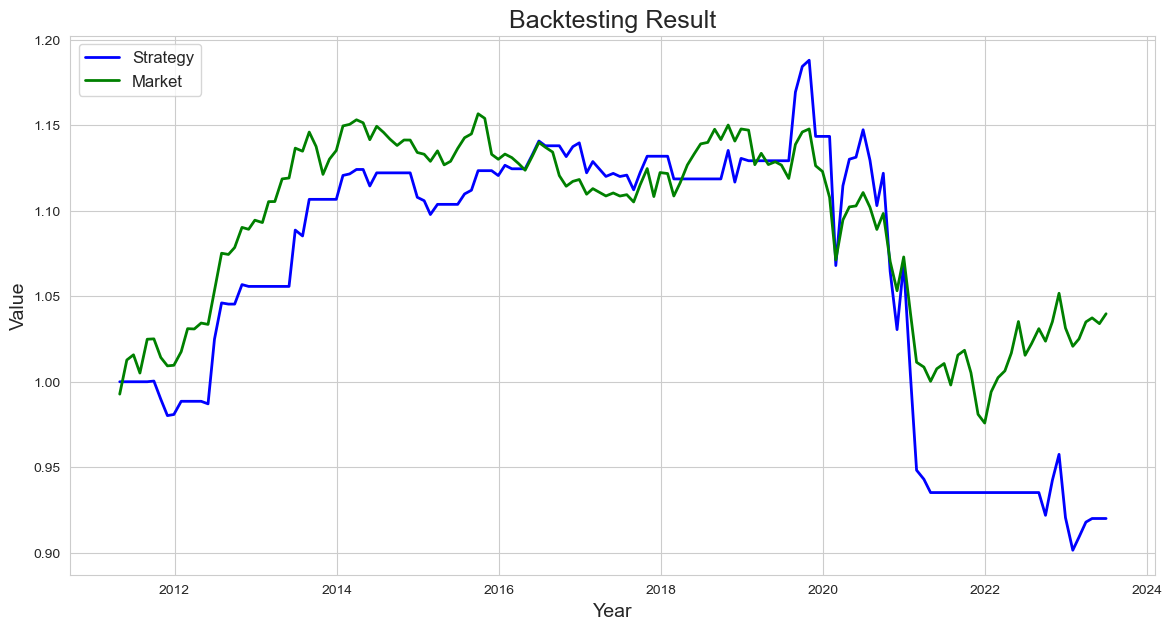

In [3]:
#clean code - plot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(file_path, index_col, parse_dates):
    data = pd.read_csv(file_path, index_col=index_col, parse_dates=parse_dates)
    return data

def calculate_strategy_results(data):
    data['strategy_return'] = data['m_return'] * data['y_pred']
    data['market_value'] = (data['m_return'] + 1).cumprod()
    data['portfolio_value'] = (data['strategy_return'] + 1).cumprod()
    return data

def calculate_performance_metrics(data):
    years = len(data) / 12 
    final_portfolio_value = data['portfolio_value'].iloc[-1]
    final_market_value = data['market_value'].iloc[-1]
    CAGR_portfolio = (final_portfolio_value / data['portfolio_value'].iloc[0]) ** (1/years) - 1
    CAGR_market = (final_market_value / data['market_value'].iloc[0]) ** (1/years) - 1
    
    rolling_max_portfolio = data['portfolio_value'].cummax()
    rolling_max_market = data['market_value'].cummax()
    daily_drawdown_portfolio = data['portfolio_value']/rolling_max_portfolio - 1.0
    daily_drawdown_market = data['market_value']/rolling_max_market - 1.0
    MDD_portfolio = daily_drawdown_portfolio.min()
    MDD_market = daily_drawdown_market.min()
    
    std_dev_portfolio = data['strategy_return'].std() * np.sqrt(12)
    std_dev_market = data['m_return'].std() * np.sqrt(12)
    Sharpe_ratio_portfolio = (CAGR_portfolio) / std_dev_portfolio
    Sharpe_ratio_market = (CAGR_market) / std_dev_market
    
    result = pd.DataFrame({
        '지표': ['CAGR', 'MDD', 'Sharpe Ratio'],
        '머신러닝 전략': [CAGR_portfolio, MDD_portfolio, Sharpe_ratio_portfolio],
        'buy&hold': [CAGR_market, MDD_market, Sharpe_ratio_market]
    })
    return result

def plot_results(data):
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['portfolio_value'], label='Strategy', color='b', linewidth=2)
    plt.plot(data.index, data['market_value'], label='Market', color='g', linewidth=2)
    plt.title('Backtesting Result', fontsize=18)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.show()

# 사용 예시
data = load_data('real_ks200_test.csv', 'base_date', True)
data = calculate_strategy_results(data)
performance_metrics = calculate_performance_metrics(data)

print(performance_metrics)

plot_results(data)



< AI 모델: 예측 >
예측:  ['down']

[클래스] : [확률]
down    : 0.76
neutral : 0.15
up      : 0.09


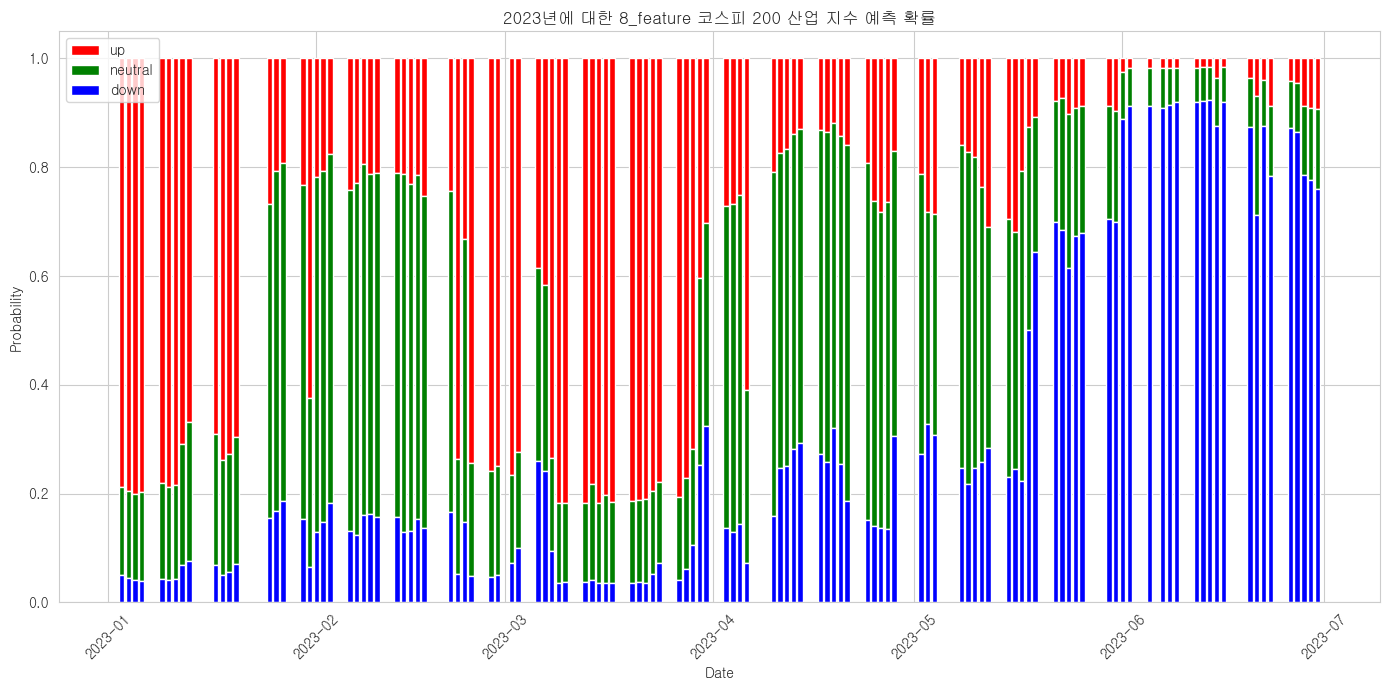

In [4]:
#clean code - Probability

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager, rc

# Korean font path
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

def load_model_and_data(model_path, data_path):
    model = joblib.load(model_path)
    data = pd.read_csv(data_path, index_col='날짜', parse_dates=True)
    return model, data

def encode_labels(y):
    encoder = LabelEncoder()
    return encoder, encoder.fit_transform(y)

def train_model(model, X, y_encoded):
    model.fit(X, y_encoded)
    return model

def predict_current_data(model, X, encoder):
    X_current = np.array(X.iloc[-1]).reshape(1,-1)
    y_current_pred = model.predict(X_current)
    prob_current = model.predict_proba(X_current)
    return encoder.inverse_transform(y_current_pred), prob_current

def plot_prediction_probability(prob, year, encoder, industry_name):
    try:
        prob_year = prob.loc[str(year)]
    except KeyError:
        print(f"{year} 레이블로 데이터를 찾을 수 없습니다. 인덱스를 확인해주세요.")
    else:
        plt.figure(figsize=(14, 7))
        plt.bar(prob_year.index, prob_year['up'], label='up', bottom=prob_year['neutral']+prob_year['down'], color='r')
        plt.bar(prob_year.index, prob_year['neutral'], label='neutral', bottom=prob_year['down'], color='g')
        plt.bar(prob_year.index, prob_year['down'], label='down', color='b')
        plt.legend()
        plt.title(f"{year}년에 대한 {industry_name} 산업 지수 예측 확률")
        plt.xlabel('Date')
        plt.ylabel('Probability')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 사용 예시
MODEL_PATH = "real_ks200.pkl"
DATA_PATH = "real_ks200.csv"
industry_name = '8_feature 코스피 200'
year_to_plot = 2023  # 년도를 인자로 받음

rnd_clf, model_data = load_model_and_data(MODEL_PATH, DATA_PATH)
X = model_data.iloc[:, 1:]
y = model_data["레이블"]
encoder, y_encoded = encode_labels(y)
trained_model = train_model(rnd_clf, X, y_encoded)

current_pred, prob_current = predict_current_data(trained_model, X, encoder)
print("\n< AI 모델: 예측 >")
print("예측: ", current_pred)

# 예측의 확률을 출력합니다.
print("\n[클래스] : [확률]")
for name, prob in zip(encoder.classes_, prob_current[0]):
    print(f"{name:7} : {prob:.2f}")

prob = trained_model.predict_proba(X)
prob_df = pd.DataFrame(prob, index=y.index, columns=encoder.classes_)

plot_prediction_probability(prob_df, year_to_plot, encoder, industry_name)



< AI 모델: 예측 >
예측:  ['down']

[클래스] : [확률]
down    : 0.76
neutral : 0.15
up      : 0.09


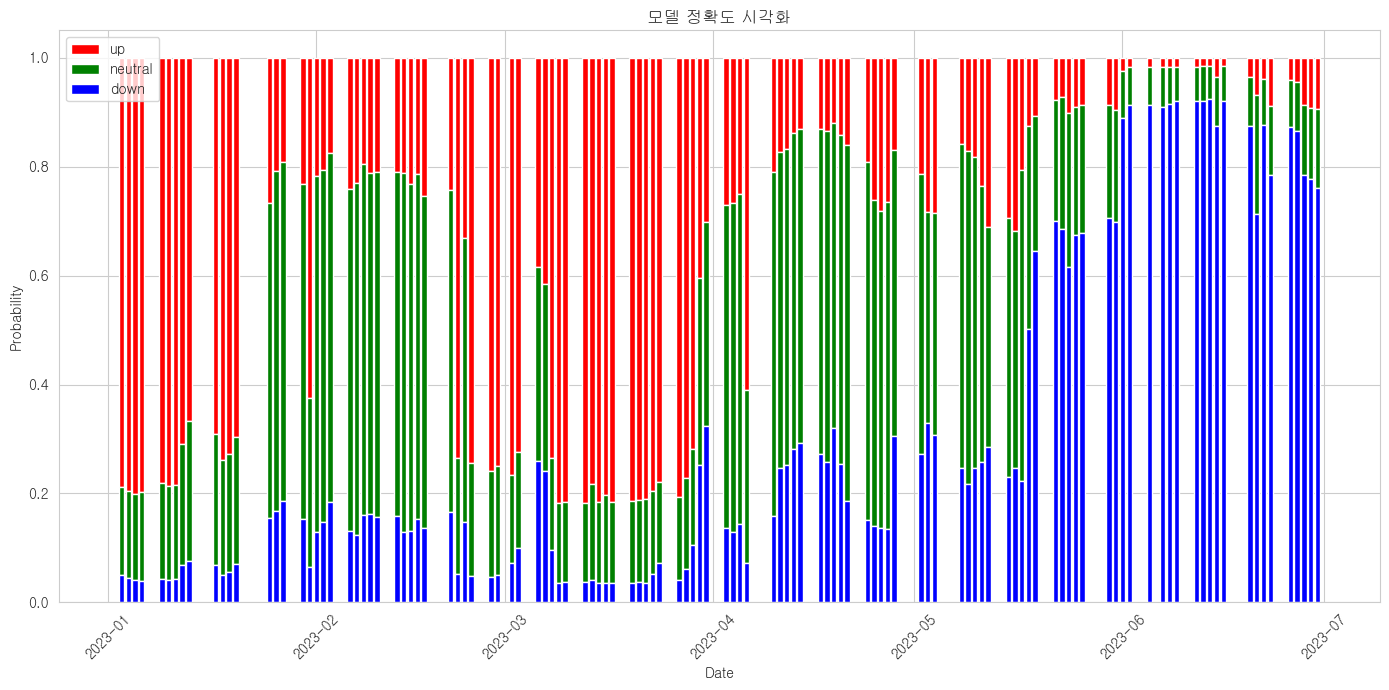

In [6]:
#clean code - Probability
# 타이틀 수정

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager, rc

# Korean font path
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

def load_model_and_data(model_path, data_path):
    model = joblib.load(model_path)
    data = pd.read_csv(data_path, index_col='날짜', parse_dates=True)
    return model, data

def encode_labels(y):
    encoder = LabelEncoder()
    return encoder, encoder.fit_transform(y)

def train_model(model, X, y_encoded):
    model.fit(X, y_encoded)
    return model

def predict_current_data(model, X, encoder):
    X_current = np.array(X.iloc[-1]).reshape(1,-1)
    y_current_pred = model.predict(X_current)
    prob_current = model.predict_proba(X_current)
    return encoder.inverse_transform(y_current_pred), prob_current

def plot_prediction_probability(prob, year, encoder, industry_name):
    try:
        prob_year = prob.loc[str(year)]
    except KeyError:
        print(f"{year} 레이블로 데이터를 찾을 수 없습니다. 인덱스를 확인해주세요.")
    else:
        plt.figure(figsize=(14, 7))
        plt.bar(prob_year.index, prob_year['up'], label='up', bottom=prob_year['neutral']+prob_year['down'], color='r')
        plt.bar(prob_year.index, prob_year['neutral'], label='neutral', bottom=prob_year['down'], color='g')
        plt.bar(prob_year.index, prob_year['down'], label='down', color='b')
        plt.legend()
        plt.title('모델 정확도 시각화')
        plt.xlabel('Date')
        plt.ylabel('Probability')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 사용 예시
MODEL_PATH = "real_ks200.pkl"
DATA_PATH = "real_ks200.csv"
industry_name = '8_feature 코스피 200'
year_to_plot = 2023  # 년도를 인자로 받음

rnd_clf, model_data = load_model_and_data(MODEL_PATH, DATA_PATH)
X = model_data.iloc[:, 1:]
y = model_data["레이블"]
encoder, y_encoded = encode_labels(y)
trained_model = train_model(rnd_clf, X, y_encoded)

current_pred, prob_current = predict_current_data(trained_model, X, encoder)
print("\n< AI 모델: 예측 >")
print("예측: ", current_pred)

# 예측의 확률을 출력합니다.
print("\n[클래스] : [확률]")
for name, prob in zip(encoder.classes_, prob_current[0]):
    print(f"{name:7} : {prob:.2f}")

prob = trained_model.predict_proba(X)
prob_df = pd.DataFrame(prob, index=y.index, columns=encoder.classes_)

plot_prediction_probability(prob_df, year_to_plot, encoder, industry_name)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
from matplotlib import font_manager, rc

# Korean font path
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
warnings.filterwarnings("ignore")

def load_model_and_data(model_path, data_path):
    model = joblib.load(model_path)
    data = pd.read_csv(data_path, index_col='날짜', parse_dates=True)
    return model, data

def encode_labels(y):
    encoder = LabelEncoder()
    return encoder, encoder.fit_transform(y)

def train_model(model, X, y_encoded):
    model.fit(X, y_encoded)
    return model

def predict_specific_data(model, X, encoder, specific_date):
    try:
        X_specific = np.array(X.loc[specific_date]).reshape(1, -1)
    except KeyError:
        print(f"{specific_date} 날짜로 데이터를 찾을 수 없습니다. 인덱스를 확인해주세요.")
        return None, None
    else:
        y_specific_pred = model.predict(X_specific)
        prob_specific = model.predict_proba(X_specific)
        return encoder.inverse_transform(y_specific_pred), prob_specific

def plot_prediction_probability_on_date(prob, date, encoder, industry_name):
    try:
        prob_date = prob.loc[date]
    except KeyError:
        print(f"{date} 레이블로 데이터를 찾을 수 없습니다. 인덱스를 확인해주세요.")
    else:
        plt.figure(figsize=(10, 6))
        plt.bar(encoder.classes_, prob_date, color=['r', 'g', 'b'])
        plt.title(f"{date}에 대한 {industry_name} 산업 지수 예측 확률")
        plt.xlabel('Class')
        plt.ylabel('Probability')
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.show()

# 사용 예시
MODEL_PATH = "ks200.pkl"
DATA_PATH = "../main/ks200.csv"
industry_name = '코스피 200'
specific_date = "2023-04-06"  # 특정 날짜를 인자로 받음

rnd_clf, model_data = load_model_and_data(MODEL_PATH, DATA_PATH)
X = model_data.iloc[:, 1:]
y = model_data["레이블"]
encoder, y_encoded = encode_labels(y)
trained_model = train_model(rnd_clf, X, y_encoded)

# 특정 날짜에 대한 예측
specific_pred, prob_specific = predict_specific_data(trained_model, X, encoder, specific_date)

if specific_pred is not None and prob_specific is not None:
    print("\n< AI 모델: 예측 >")
    print(f"{specific_date} 예측: ", specific_pred)
    
    # 예측의 확률을 출력합니다.
    print("\n[클래스] : [확률]")
    for name, prob in zip(encoder.classes_, prob_specific[0]):
        print(f"{name:7} : {prob:.2f}")
    
    prob = trained_model.predict_proba(X)
    prob_df = pd.DataFrame(prob, index=y.index, columns=encoder.classes_)
    
    # 특정 날짜의 예측 확률을 시각화합니다.
    plot_prediction_probability_on_date(prob_df, specific_date, encoder, industry_name)


ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}